## Using cross_validate to Compare Methods

In [1]:
import pandas as pd
import useful_rdkit_utils as uru
from rdkit.Chem import rdFingerprintGenerator
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from rdkit import Chem
from catboost import CatBoostRegressor
from sort_and_slice_ecfp_featuriser import create_sort_and_slice_ecfp_featuriser
import pingouin as pg
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List

/Users/pwalters/miniconda3/envs/rdkit_2023_05/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


The **cross_validate** function provides a flexible means of running nested cross-validation experiments. It's easy to compare descriptors, machine learing models or combinations of the two.  The function allows easy incorporation of different splitting strategies.  Random, scaffold, and cluster splits are supported out of the box. Other strategies can be trivially incorporated. Finally, any set of metrics that follow the conventions in sklearn.metrics can be incorporated. 

The function accepts a few arguments.  
- **df** - A Pandas dataframe, the dataframe must have a SMILES column 
- **model_list** - a list of tuples where the first element is a string indicating the model name, the second element is a function that returns a scikit-learn compatible model 
- **y_col** - the column in **df** with the y value for the model 
- **descriptor_list** - a list of tuples, where the the first element is the descriptor name and the second element contains a function to calculate descriptors for training and test sets.  The function takes three argments, the descriptor name, a dataframe with the training set, and a dataframe with the test set. 
- **group_list** - a list of tuples where the first element contains the group name and the second argment is a function to caculate the groups.  This argment can be used to split according to groups (e.g. scaffold or cluster splitting).  To perform a random split, set each row in df to a unique value. 
- **metric_list** - a list of metrics to calculate (e.g. r2_score, mean_absolute_error).  The functions should use the sklearn.metrics convention where the first argment is a list of true values and the second argument is a list of predicted values. 
- **n_outer** - the number of rounds of cross validation
- **n_inner** - the number of splits to perform at each round 

The return value is a list of dictionaries that can be easily transformed into a Pandas dataframe.  More on this below. 

Here's the docstring. 

In [2]:
help(uru.cross_validate)

Help on function cross_validate in module useful_rdkit_utils.split_utils:

cross_validate(df: pandas.core.frame.DataFrame, model_list: List[Tuple[str, Callable]], y_col: str, descriptor_list: List[Tuple[str, Callable]], group_list: List[Tuple[str, Callable]], metric_list: List[Tuple[str, Callable]], n_outer: int = 5, n_inner: int = 5) -> List[dict]
    Perform cross-validation on a given dataset.
    
    :param df: The input pandas DataFrame.
    :param model_list: A list of tuples where each tuple contains a model name and a function to create the model.
    :param y_col: The name of the target column in the DataFrame.
    :param descriptor_list: A list of tuples where each tuple contains a descriptor name and a function to calculate the descriptor.
    :param group_list: A list of tuples where each tuple contains a group name and a function to calculate the group.
    :param metric_list: A list of tuples where each tuple contains a metric name and a function to calculate the metric.

The best way to explain **cross_validate** is with an example.  Let's compare the Morgan counts fingerprint from theh RDKit with the recently published [Sort and Slice fingerprint](https://arxiv.org/abs/2403.17954).  We'll examine the input argments one at a time. 

### df
The input dataframe must have two components. 
- A SMILES column titled **SMILES**
- A column with a y-value, this can have any name 

First we'll read in some data.  We'll use the solubility set from the [Biogen ADME datasets](https://github.com/molecularinformatics/Computational-ADME). 

In [3]:
df = pd.read_csv("/Users/pwalters/modsource/python/rdkit/sort_and_slice/biogen_logS.csv")
df.head()

,Internal ID,Vendor ID,SMILES,CollectionName,logS
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,-5.548020
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,-5.071409
2,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,-3.925969
3,Mol6,316230505,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,emolecules,-4.535280
4,Mol9,EN300-97039,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,enamineBB_pmc,-4.709963


### model_list
ML models are defined with a simple function that returns a scikit-learn compatible model.  The model must support the **fit** and **predict** methods. Calling the functions this way enables arguments to be passed to the model. 

In [4]:
# define functions 
def gen_LGBMRegressor():
    return LGBMRegressor()

def gen_CatBoostRegressor():
    return CatBoostRegressor(verbose=False)

# create a list of names and functions
model_list = [["LGBM",gen_LGBMRegressor],["CatBoost",gen_CatBoostRegressor]]

### y_col
The **y_col** argument specifies the **y** variable.  In this case, it's **logS**. 

In [5]:
df.head()

,Internal ID,Vendor ID,SMILES,CollectionName,logS
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,-5.548020
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,-5.071409
2,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,-3.925969
3,Mol6,316230505,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,emolecules,-4.535280
4,Mol9,EN300-97039,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,enamineBB_pmc,-4.709963


### descriptor_list

Here are two functions to caculate descriptors.   We can the combine the functions in a list. 

In [6]:
# define functions
def calc_morgan_count_fps(fp_name, train, test): 
    train['mol'] = train.SMILES.apply(Chem.MolFromSmiles)
    test['mol'] = test.SMILES.apply(Chem.MolFromSmiles)
    fg = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)
    train[fp_name] = train.mol.apply(fg.GetCountFingerprintAsNumPy)
    test[fp_name] = test.mol.apply(fg.GetCountFingerprintAsNumPy)

def calc_sort_and_slice_fps(fp_name, train, test):
    train['mol'] = train.SMILES.apply(Chem.MolFromSmiles)
    test['mol'] = test.SMILES.apply(Chem.MolFromSmiles)
    featurizer = create_sort_and_slice_ecfp_featuriser(train.mol,print_train_set_info=False)
    train[fp_name] = [featurizer(x) for x in train.mol]
    test[fp_name] = [featurizer(x) for x in test.mol]
    
# create a list of names and functions  
descriptor_list = [["morgan_counts", calc_morgan_count_fps],["sort_and_slice",calc_sort_and_slice_fps]]

### group_list
Splitting functions take a SMILES list as input and return a list of integers corresponding to groups.  Here are a couple of examples.  The first takes a list of SMILES and returns a unique index for each.  This just produces a random split.   The second takes the same input and returns a list of cluster ids.  The *cross_validation* function will not put molecules from the same cluster into both training and test sets. 

The **useful_rdkit_utils** library has four splitting functions.  
- get_random_split
- get_bemis_murcko_clusters
- get_butina_clusters 
- get_kmeans clusters

The code below shows how these functions are implemented. 

In [18]:
# define functions
def get_random_split(smiles_list):
    return list(range(0, len(smiles_list)))

def get_butina_clusters(smiles_list):
    fp_list = [uru.smi2morgan_fp(x) for x in smiles_list]
    return uru.taylor_butina_clustering(fp_list)

# create a list of names and functions 
group_list = [["butina",uru.get_butina_clusters],["random",simple_random_split]]

Now let's apply **cross_validate**.  We will define 

One model  
- LGBMRegressor (Light Gradient Boosting Machine Regressor)

Two sets of descriptors  
- morgan_counts (RDKit Morgan fingerprints with counts)
- sort_and_slice (Sort and Slice fingerprint) 

One grouping method
- butina (split based on Butina clustering) 

Two metrics
- R2 (coefficient of determination) 
- MAE (mean absolute error)


In [8]:
model_list = [["LGBM",gen_LGBMRegressor]]
descriptor_list = [["morgan_counts", calc_morgan_count_fps],["sort_and_slice",calc_sort_and_slice_fps]]
group_list = [["butina",uru.get_butina_clusters]]
metric_list = [["R2",r2_score],["MAE",mean_absolute_error]]

Run **cross_validate**

In [9]:
result_list = uru.cross_validate(df, model_list, "logS", descriptor_list, group_list, metric_list, 5, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Turn the results into a dataframe. 

In [10]:
result_df = pd.DataFrame(result_list)
result_df.head()

,group,model,desc,fold,R2,MAE
0,butina,LGBM,morgan_counts,0,0.329274,0.409787
1,butina,LGBM,sort_and_slice,0,0.311711,0.416377
2,butina,LGBM,morgan_counts,1,0.401879,0.421149
3,butina,LGBM,sort_and_slice,1,0.399816,0.416558
4,butina,LGBM,morgan_counts,2,0.305655,0.371785


Plot the $R^2$ and MAE distributions to see if they're roughly normal. 

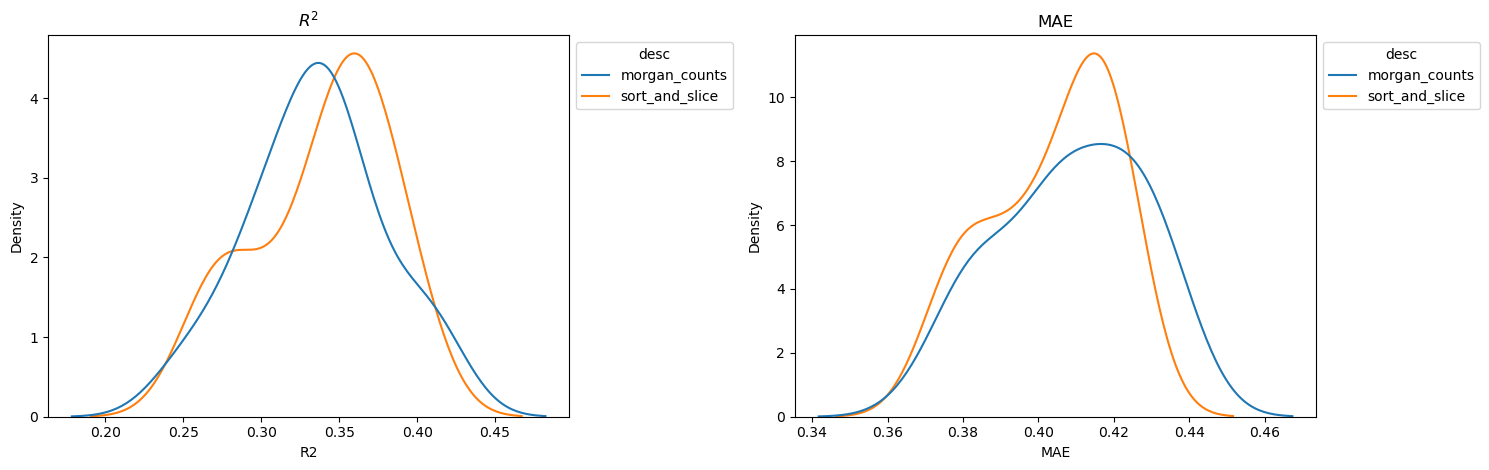

In [11]:
figure, axes = plt.subplots(1,2)
figure.set_figwidth(15)
ax0 = sns.kdeplot(x="R2",hue="desc",data=result_df,ax=axes[0])
sns.move_legend(ax0, "upper left", bbox_to_anchor=(1, 1))
ax0.set_title("$R^2$")
ax1 = sns.kdeplot(x="MAE",hue="desc",data=result_df,ax=axes[1])
ax1.set_title("MAE")
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()

Calculate p-values

In [12]:
morgan = result_df.query("desc == 'morgan_counts'")
sort_slice = result_df.query("desc == 'sort_and_slice'")
ttest_ind(morgan.R2, sort_slice.R2).pvalue,ttest_ind(morgan.MAE, sort_slice.MAE).pvalue

(0.7363660118002687, 0.3229958521473353)

Calculate Cohen's d

In [13]:
def cohen_d(s1,s2):
    s1 = s1.values
    s2 = s2.values
    return np.abs(np.mean(s1-s2)/np.std(s1-s2))

In [14]:
cohen_d(morgan.R2,sort_slice.R2),cohen_d(morgan.MAE, sort_slice.MAE)

(0.17927618171299872, 0.5041341659256958)

Transform the dataframe for plots

In [15]:
result_df["idx"] = range(0,len(result_df))
id_vars = ["idx","group","fold","model","desc"]
melt_df = result_df.drop("MAE",axis=1).query("group == 'butina' and model == 'LGBM'").melt(id_vars=id_vars)
melt_df.head()

,idx,group,fold,model,desc,variable,value
0,0,butina,0,LGBM,morgan_counts,R2,0.329274
1,1,butina,0,LGBM,sort_and_slice,R2,0.311711
2,2,butina,1,LGBM,morgan_counts,R2,0.401879
3,3,butina,1,LGBM,sort_and_slice,R2,0.399816
4,4,butina,2,LGBM,morgan_counts,R2,0.305655


I find the [paired plot](https://pingouin-stats.org/build/html/generated/pingouin.plot_paired.html) from pingouin to be a useful visual for comparing models.  The plot shows boxplots of the metrics from two variants.  In this case, we're comparing two fingerprint types.  We have lines connecting individual values, with an increase between methods in green and a decrease in red.  Each line represents one cross-validation fold. Ideally, we'd like to see the same color for all the lines.  If we see some red lines and some green lines this indicates less of a difference between methods. Here's the paired plot for $R^2$"

Text(0.5, 1.0, '$R^2$')

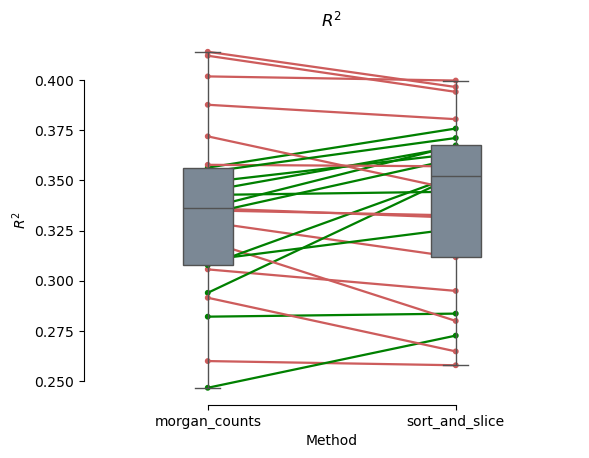

In [16]:
ax = pg.plot_paired(melt_df, dv="value",subject="fold",within="desc")
ax.set_xlabel("Method")
ax.set_ylabel("$R^2$");
ax.set_title("$R^2$")

Make a paired plot for MAE

Text(0.5, 1.0, 'MAE')

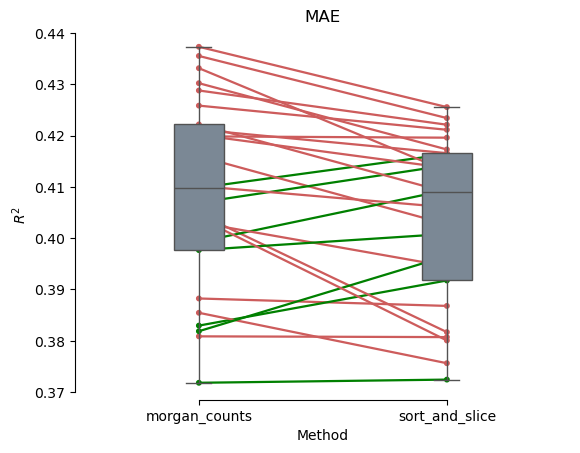

In [17]:
melt_df = result_df.drop("R2",axis=1).query("group == 'butina' and model == 'LGBM'").melt(id_vars=id_vars)
ax = pg.plot_paired(melt_df, dv="value",subject="fold",within="desc")
ax.set_xlabel("Method")
ax.set_ylabel("$R^2$");
ax.set_title("MAE")